In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'
import pickle
import numpy as np
import json
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, make_zscore_df, create_zscore_df

In [2]:
def create_spread_hist_df(token_1, token_2, min_order, method, curr_order, hours_back):
    curr_order = orders.filter(
        (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2)
    ).tail(1)

    tf = curr_order['tf'][0]
    wind = curr_order['wind'][0]
    train_len = int(tf[0]) * wind * 2

    ct = curr_order['ct'][0]
    st_time = datetime.strptime(ct, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
    valid_time = st_time - timedelta(hours = hours_back)
    start_time = valid_time - timedelta(hours = train_len)
    thresh_in = curr_order['thresh_in'][0]
    thresh_out = curr_order['thresh_out'][0]
    side = curr_order['side'][0]

    df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time)
    df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time)

    df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time,
                             )

    if tf == '1h':
        agg_df = make_trunc_df(df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')[:-1]
    elif tf == '4h':
        agg_df = make_trunc_df(df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')[:-1]
    else:
        raise NotImplementedError('Введите верный таймфрейм ("1h", "4h")')

    df_sec = make_trunc_df(df, timeframe='1s', token_1=token_1, token_2=token_2, start_date=valid_time, method='last', return_bid_ask=True)

    result_df = create_zscore_df(token_1, token_2, df_sec, agg_df, np.array((wind,)), method, min_order)

    result_df = result_df.select('time', token_1, token_2, f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'beta_{wind}', f'z_score_{wind}').rename(
        {f'beta_{wind}': 'beta', f'z_score_{wind}': 'z_score'}
                    )
    return result_df

In [3]:
def plot_graphs(current_pairs, thr_in, thr_out):
    for row in current_pairs.iter_rows(named=True):
        token_1 = row['token_1']
        token_2 = row['token_2']
        side = row['side_1']
        t1_name = token_1[:-5]
        t2_name = token_2[:-5]
        open_time = row['created_at']

        tf = '4h'
        wind = 24

        start_ts = int(datetime.timestamp(open_time))
        end_ts = int(datetime.timestamp(datetime.now()))
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)

        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)

        fig, ax1 = plt.subplots(figsize=(14, 3))

        # График z_score
        ax1.plot(hist.select('time'), hist.select(f'z_score'), color='blue', label='z_score', ls='-', lw=0.75)
        ax1.set_title(f'{token_1[:-5]} - {token_2[:-5]} ({side}; tf: {tf}; wind: {wind}). z_score: {curr_zscore}; profit: {curr_profit}')

        ax1.set_ylabel('z_score')

        if side == 'long':
            ax1.axhline(-thr_in, c='g', linestyle='dotted')
            ax1.axhline(thr_out, c='r', linestyle='dotted')
        else:
            ax1.axhline(thr_in, c='g', linestyle='dotted')
            ax1.axhline(-thr_out, c='r', linestyle='dotted')

        # График профита
        ax2 = ax1.twinx()
        ax2.plot(hist.select('time'), hist.select('profit'), color='green', label='profit', lw=2.0)
        ax2.set_ylabel('profit')
        ax2.grid()
        plt.tight_layout()
        fig.legend(loc='upper right', bbox_to_anchor=(0.135, 0.9))
        plt.show()

In [23]:
current_pairs = db_manager.get_table('pairs', df_type='polars')

for row in current_pairs.iter_rows(named=True):
    token_1 = row['token_1']
    token_2 = row['token_2']
    side = row['side_1']
    t1_name = token_1[:-5]
    t2_name = token_2[:-5]
    open_time = row['created_at']

    tf = '4h'
    wind = 18

    end_ts = int(datetime.timestamp(datetime.now()))
    start_ts = end_ts - 60

    try:
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)
        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} ({side:>5}, tf: {tf}; wind: {wind:>2}): z_score: {curr_zscore:5}; profit: {curr_profit:5}')
    except IndexError:
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} ({side:>5}, tf: {tf}; wind: {wind:>2}): z_score: NaN; profit: NaN')
    



   CHZ - VET    (short, tf: 4h; wind: 18): z_score:  2.03; profit: -0.06
   GMT - BLUR   (short, tf: 4h; wind: 18): z_score:  2.19; profit: -0.21


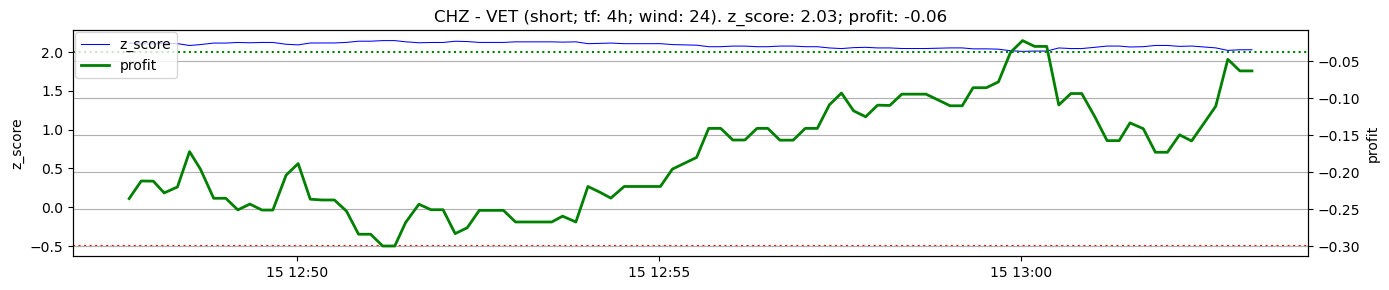

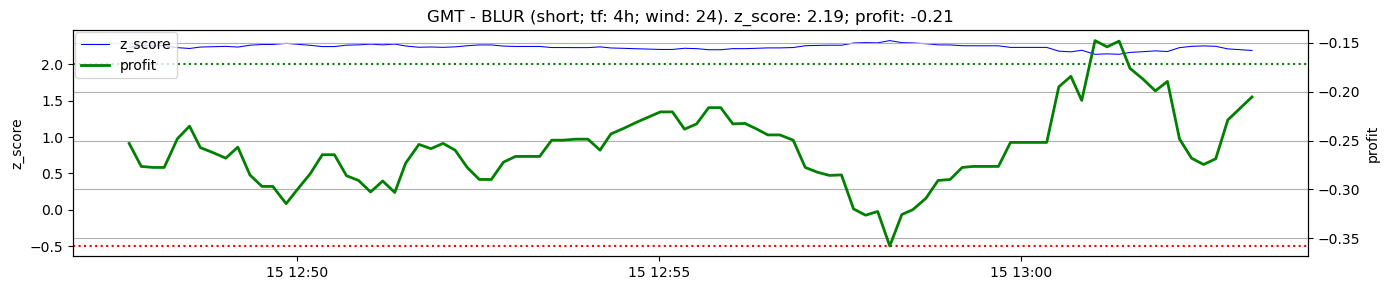

In [24]:
plot_graphs(current_pairs, thr_in=2.0, thr_out=0.5)

In [ ]:
# CELO - IMX: график z_score растёт, а профит падает. И наоборот.
# GRT - MANTA: график профита идёт в противоположенном направлении тому, что должен.

# IMX - LDO - прям хороший график, где профит полностью повторяет z_score

In [ ]:
# Разобрать
# RENDER - XRP

In [25]:
pairs = db_manager.get_table('pairs', df_type='polars')
pairs.select('token_1', 'token_2', 'created_at', 'mode', 'side_1', 'qty_1', 'qty_2', 'usdt_1', 'usdt_2',
            'rpnl_1', 'rpnl_2', 'upnl_1', 'upnl_2', 'profit_1', 'profit_2', 'profit', 'status')

token_1,token_2,created_at,mode,side_1,qty_1,qty_2,usdt_1,usdt_2,rpnl_1,rpnl_2,upnl_1,upnl_2,profit_1,profit_2,profit,status
str,str,"datetime[μs, Europe/Moscow]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""CHZ_USDT""","""VET_USDT""",2025-11-15 12:47:32 MSK,"""demo""","""short""",3135.0,6362.0,49.87785,49.9417,-0.054883,-0.054901,0.1881,0.0,0.133217,-0.054901,0.078316,"""active"""
"""GMT_USDT""","""BLUR_USDT""",2025-11-15 12:47:32 MSK,"""demo""","""short""",4512.0,2362.0,49.88016,49.94449,-0.054868,-0.054939,0.2256,-0.16534,0.170732,-0.220279,-0.049547,"""active"""


In [26]:
token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [27]:
td = 240
end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
start_time = end_time - timedelta(hours = td)

In [28]:
hist_df = db_manager.get_orderbooks(interval='4h', start_date=start_time)
hist_df = hist_df.with_columns(pl.col('price').alias('avg_price'))

In [29]:
from bot.utils.pair_trading import get_lr_zscore, get_dist_zscore

In [30]:
wind = 24

current_data = db_manager.get_table('current_ob', df_type='polars')
current_data = current_data.with_columns(
                    ((pl.col('bid_price_0') + pl.col('ask_price_0')) / 2.0).alias('avg_price')
                )

min_order = 40
end_t = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
st_t = end_t - timedelta(seconds = 30)

tick_df = db_manager.get_tick_ob(start_time=st_t).with_columns(
    ((pl.col('bid_price') + pl.col('ask_price')) / 2.0).alias('avg_price')
).filter(
    (pl.col('bid_size') * pl.col('bid_price') > min_order) &
    (pl.col('ask_size') * pl.col('ask_price') > min_order)
)

for t1_name, t2_name in token_pairs:
    token_1 = t1_name + '_USDT'
    token_2 = t2_name + '_USDT'
    z_score = 0

    t1_tick_df = tick_df.filter(pl.col('token') == token_1)
    t2_tick_df = tick_df.filter(pl.col('token') == token_2)
    
    token_1_hist_price = hist_df.filter(pl.col('token') == token_1).tail(2 * wind + 1)['avg_price'].to_numpy()
    token_2_hist_price = hist_df.filter(pl.col('token') == token_2).tail(2 * wind + 1)['avg_price'].to_numpy()

    # --- Получаем текущие цены ---
    t1_curr_data = current_data.filter(pl.col('token') == token_1)
    t2_curr_data = current_data.filter(pl.col('token') == token_2)
    t1_curr = np.append(token_1_hist_price, t1_curr_data['avg_price'][0])
    t2_curr = np.append(token_2_hist_price, t2_curr_data['avg_price'][0])

    _, _, _, _, beta_curr, zscore_curr = get_lr_zscore(t1_curr, t2_curr, np.array([wind]))
    z_score_curr = zscore_curr[0]

    if t1_tick_df.height < 3 or t2_tick_df.height < 3:
        print(f'{token_1:>12} - {token_2:12}: z_score tick:    NaN; curr: {z_score_curr:6.2f}')
        continue
    
    t1_med = np.append(token_1_hist_price, t1_tick_df['avg_price'].median())
    t2_med = np.append(token_2_hist_price, t2_tick_df['avg_price'].median())
    
    _, _, zscore = get_dist_zscore(t1_med, t2_med, np.array([wind]))
    z_score = zscore[0]

    print(f'{token_1[:-5]:>6} - {token_2[:-5]:6}: z_score tick: {z_score:6.2f}; curr: {z_score_curr:6.2f}')

  IOTA - CELO  : z_score tick:   1.33; curr:  -0.28
  FLOW - MANTA : z_score tick:  -1.03; curr:   0.09
  ARKM - OP    : z_score tick:  -1.00; curr:   0.07
 SUSHI - STX   : z_score tick:   1.49; curr:  -0.21
   ARB - SAND  : z_score tick:  -0.62; curr:   0.58
   IMX - LDO   : z_score tick:  -1.38; curr:  -0.33
   GMT - BLUR  : z_score tick:   2.17; curr:   1.85
   DOT - RENDER: z_score tick:   1.24; curr:   1.03
  DYDX - SEI   : z_score tick:   0.08; curr:  -1.17
   CHZ - VET   : z_score tick:   2.00; curr:   1.80
